In [50]:
#!pip install tensorflow-addons

In [51]:
#!pip install wandb
import wandb
#wandb.login()
#1c958d778981a5d39875934a429540ec84470ee5

In [52]:
#import wandb
#import tensorflow as tf

#wandb.init(project="SCL", entity="engineerjkk")

## Introduction

Supervised Contrastive Leanring is a traning methodology that outperforms supervised training with crossentropy on classification tasks.  

Essentially, training an image classification model with Supervised Contrastive Learning is perfomed in two phases:  

1. Training an encoder to learn to produce vector representations of input images such that representations of images in the same class will be more similar compared to representations of images in different classes.  
2. Training a classifier on top of the frozen encoder.  


- CIFAR10 데이터셋을 사용한다.
- 클래스 수는 10개이며, 32 by 32 pixels의 3채널을 갖는 컬러이미지 데이터셋이다.

In [53]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

x is a image dataset and y is a label set

In [54]:

num_classes = 10
input_shape = (32, 32, 3)

# Load the train and test data splits
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Display shapes of train and test datasets
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


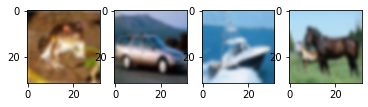

In [55]:
import matplotlib.pyplot as plt
plt.subplot(141)
plt.imshow(x_train[0], interpolation="bicubic")
plt.grid(False)
plt.subplot(142)
plt.imshow(x_train[4], interpolation="bicubic")
plt.grid(False)
plt.subplot(143)
plt.imshow(x_train[8], interpolation="bicubic")
plt.grid(False)
plt.subplot(144)
plt.imshow(x_train[12], interpolation="bicubic")
plt.grid(False)
plt.show()

In [56]:

data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.RandomFlip("horizontal"),#랜덤으로 가로로 뒤집어줌.
        layers.RandomRotation(0.02),#랜덤으로 0.02만큼 Rotation을 수행해줌.
        layers.RandomWidth(0.2),#width를 0.2만큼 늘려준다.
        layers.RandomHeight(0.2),#Height를 0.2만큼 늘려준다. 
    ]
)

# Setting the state of the normalization layer.
data_augmentation.layers[0].adapt(x_train)

# Build the encoder model  

The encoder model takes the image as input and turns it into a 2048-dimensional feature vector.

### Args <- keras.applications.ResNet50V2
- include_top : whether to include the fully-connected layer at the top of the network.  

- weight : one of None (random initialization), 'imagenet' (pre-training on ImageNet), or the path to the weights file to be loaded.  

- input_shape : optional shape tuple, only to be specified if include_top is False (otherwise the input shape has to be (224, 224, 3)(with 'channels_last' data format) or (3, 224, 224)(with 'channels_first' data format). 
It should have exactly 3 inputs channels, and width and height should be no smaller than 32.E.g. (200, 200, 3) would be one valid value.   

- pooling : Optinal pooling mode for feature extraction when include_top is False.  
    - **None** means that the output of the model will be the 4D tensor output of the last convolutional block.
    - **avg** means that global average pooling will be applied to the output of the last convolutional block, and thus the output of the model will be a 2D tensor.  
    - **max** means that global max pooling will be applied.

2) Encoder Network.  

It simply converts the image into a representation vector.   
The authors used headless ResNet-50 and ResNet-200 as the base model for the encoder network and got some fantastic results.   
The augmented images of the input image we got from the data augmentation module are sent to the same encoder separately, which outputs a pair of representation vectors.   
These outputs are normalized values.   
This means one input image will have two representations.  

In [57]:
wandb.config = {
  "learning_rate": 0.001,
  "epochs": 50,
  "batch_size": 256
}


In [80]:
def create_encoder():
    #ResNet 내부 파라미터를 설정한다. include_top을 False를 함으로써 FC Layer를 안줘서 Feature Task만 사용한다.
    resnet = keras.applications.ResNet50V2(
        include_top=False, weights=None, input_shape=input_shape, pooling="avg"
    )
    

    inputs = keras.Input(shape=input_shape)
    augmented = data_augmentation(inputs)
    outputs = resnet(augmented)#augmented된 이미지를 넣어준다. 
    model = keras.Model(inputs=inputs, outputs=outputs, name="cifar10-encoder")
    return model


encoder = create_encoder()#create_encoder를 통해서 모델을 만든다. 
encoder.summary()#아래 encoder에 대한 summary가 출력된다.

learning_rate = 0.001
batch_size = 256 #6144 #265
hidden_units = 512
projection_units = 128
num_epochs = 1
dropout_rate = 0.5
temperature = 0.05
#32 by 32 사이즈의 3채널 이미지가 input으로 들어오게되며, 최종 출력되는 차원은 2048 dimension의 feature vector가 출력된다.
#Fully Connected Layer가 없으므로 2048차원의 feature vector만 사용되는 것이다.

Model: "cifar10-encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 sequential_2 (Sequential)   (None, 32, 32, 3)         7         
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
Total params: 23,564,807
Trainable params: 23,519,360
Non-trainable params: 45,447
_________________________________________________________________


In [81]:
inputs = keras.Input(shape=input_shape)
augmented = data_augmentation(inputs)
augmented

<KerasTensor: shape=(None, 32, 32, 3) dtype=float32 (created by layer 'sequential_2')>

# Build the classification model

The classification model adds a fully-connected layer on top of the encoder, plus a softmax layer with the target classes.

- 이제 Stage2의 Classification model을 만들어야한다

3) Projection network.  

It converts the representation vectors into a vector suitable for contrastive loss calculation.   
The authors used a multi-layer perceptron with a single hidden layer of size 2048 and an output vector of size DP = 128.   
The encoded vectors which we get as an output from the encoder network are fed into this network.   
The output of this network i.e., the projection vectors are normalized and then used in the loss function.

In [82]:
def create_classifier(encoder, trainable=True):

    for layer in encoder.layers:
        layer.trainable = trainable

    inputs = keras.Input(shape=input_shape)
    print("input_shape :",input_shape)
    print("encoder : ",encoder)
    print("inputs : ",inputs)
    features = encoder(inputs)#input shape 32x32x3 사이즈를 넣어준다.
    features = layers.Dropout(dropout_rate)(features)#드롭아웃과함께 이전 레이어의 아웃풋을 넣어준다.
    features = layers.Dense(hidden_units, activation="relu")(features)#128차원으로 만들어주며, activation function은 relu를 사용한다.
    features = layers.Dropout(dropout_rate)(features)#다시한번 더 dropout을 사용한다. 
    outputs = layers.Dense(num_classes, activation="softmax")(features)#class 개수만큼의 차원으로 만들어준다. activation function은 softmax를 사용한다.

    model = keras.Model(inputs=inputs, outputs=outputs, name="cifar10-classifier")#이렇게 classifier 모델을 완성해준다.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),#optimizer는 Adan을 사용했으며, learning rate는 0.001을 사용한다.
        loss=keras.losses.SparseCategoricalCrossentropy(),#사용하는 cross entropy로는 sparseCetegorialCrossentropy를 사용한다. 내부적으로 알아서 one hot vector로 만들어주는 cross entropy이다. 
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )
    return model

# Experiment 1 : Train the baseline classification model  

In this experiment, a baseline classifier is trained as usual, i.e., the encoder and the classifier parts are trained together as a single model to minimize the crossentropy loss.

- encoder와 classifier 부분이 함께 하나의 모델에서 train되며, crossentropy loss를 minimize한다.

In [83]:
encoder = create_encoder()#encoder 모델을 생성해주며,
classifier = create_classifier(encoder)#인코더 모델의 output을 classifier에 넣어준다. 
classifier.summary()

history = classifier.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=num_epochs)#,callbacks=[WandbCallback()])

accuracy = classifier.evaluate(x_test, y_test)[1]
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

input_shape : (32, 32, 3)
encoder :  <keras.engine.functional.Functional object at 0x7efd601c7010>
inputs :  KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='input_30'), name='input_30', description="created by layer 'input_30'")
Model: "cifar10-classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 cifar10-encoder (Functional  (None, 2048)             23564807  
 )                                                               
                                                                 
 dropout_10 (Dropout)        (None, 2048)              0         
                                                                 
 dense_12 (Dense)            (None, 512)               1049088   
                                                 

# Experiment 2 : Use supervised contrastive learning 

In this experiment, the model is trained in two phases. In the first phase, the encoder is pretrained to optimize the supervised contrastive loss, described in [Prannay Khosla et al](https://arxiv.org/abs/2004.11362),.  
In the second phase, the classifier is trained using the trained encoder with its weights freezed  
only the weights of fully-connected layers with the softmax are optimized.  

# 1. Supervised contrastive learning loss function.
Loss Function을 제안한다.

Once the output vector of this projection network is sent to the supervised contrastive loss function(explained below), the loss is calculated and minimized.  
​​This whole operation is shown diagrammatically below.


In [84]:
class SupervisedContrastiveLoss(keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super(SupervisedContrastiveLoss, self).__init__(name=name)
        self.temperature = temperature #similarity 값을 scaling해주는 tau인 temperature 값을 1로 설정한다. 

    def __call__(self, labels, feature_vectors, sample_weight=None):
        # Normalize feature vectors
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)##veature vector를 Normalization 시켜준뒤에,
        # Compute logits 
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)#자기 자신과 autmented된 positive 또는 negative image를 곱해준다.
            ),
            self.temperature,#그리고 scaling을 위해 temperature constant로 나누어준다. 
        )
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits) #tfa.losses.npairs_loss API를 사용해서 실제 레이블된 ground true 값과 예측된 값의 pair loss를 계산한다. 


def add_projection_head(encoder):#인코더 이후에 projection head를 추가한다. MLP이다.
    inputs = keras.Input(shape=input_shape)#3채널 32 by 32의 input shape을 input으로 넣어준뒤,
    features = encoder(inputs)#인코더에 넣어준다.
    outputs = layers.Dense(projection_units, activation="relu")(features)#그리고 DenseLayer로 128차원으로 만들어주고, ReLU Activation Function을 사용한다. 
    model = keras.Model(#이렇게 input 3채널 32 by 32 사이즈 input, 128차원의 output으로 나오는 모델을 생성하여준다.
        inputs=inputs, outputs=outputs, name="cifar-encoder_with_projection-head"
    )
    return model

# 2. Pretrain the encoder
* Stage 1: In this stage, the network is trained using contrastive loss.     
Here the images are encoded in such a way that embeddings of similar classes are close and that of other classes are far.   
To do this, image labels are used.   
This stage has three components, namely data augmentation module, encoder network, and encoder network. These components are explained below separately.

In [85]:
encoder = create_encoder() #인코더를 생성해준다. 

encoder_with_projection_head = add_projection_head(encoder)#그리고 인코더에 projection head를 추가해준다. 
encoder_with_projection_head.compile(
    optimizer=keras.optimizers.Adam(learning_rate),#optimizer로는 Adam optimizer를 사용하며,
    loss=SupervisedContrastiveLoss(temperature),#Loss Function으로는 SupCon LossFunction을 사용하며, 파라미터인 temperature constant 1을 줍니다. 
)

encoder_with_projection_head.summary()#Summary를 해주고,

history = encoder_with_projection_head.fit(#x에 트레이닝셋, y에 y 트레이닝셋, batch_size는 265를 주었으며, epochs는 50을 주어 학습을 진행했습니다. 
    x=x_train, y=y_train, batch_size=batch_size, epochs=num_epochs
)

Model: "cifar-encoder_with_projection-head"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_33 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 cifar10-encoder (Functional  (None, 2048)             23564807  
 )                                                               
                                                                 
 dense_14 (Dense)            (None, 128)               262272    
                                                                 
Total params: 23,827,079
Trainable params: 23,781,632
Non-trainable params: 45,447
_________________________________________________________________
196/196 [==============================] - 14s 53ms/step - loss: 5.3317


# 3. Train the classifier with the frozen encoder.  
Stage 2: Here, the encoder network used in Stage 1 is frozen, and the projector network is discarded.  
 The representation learned from the encoder network is then used to learn a classifier, which is nothing but a linear layer.  
  At this stage, the cross-entropy loss is used to predict the labels.

In [86]:
classifier = create_classifier(encoder, trainable=False)#
#epoch 500 tau 0.05 batch 6144
history = classifier.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=num_epochs)
#classifier 모델의 fit에 x train과 y train 그리고 batch size는 256을 주었으며 epoch는 50회를 주었다. 
accuracy = classifier.evaluate(x_test, y_test)[1]
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

input_shape : (32, 32, 3)
encoder :  <keras.engine.functional.Functional object at 0x7f04685f0040>
inputs :  KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='input_34'), name='input_34', description="created by layer 'input_34'")
313/313 [==============================] - 8s 19ms/step - loss: 1.6225 - sparse_categorical_accuracy: 0.3810
Test accuracy: 38.1%


In [64]:
#!pip install wandb
#import wandb

In [65]:
#wandb.login
#

In [66]:
encoded_vector=encoder.predict(x_train)

In [67]:
encoded_vector

array([[0.        , 0.        , 1.0518253 , ..., 0.        , 0.        ,
        0.16857025],
       [0.2543722 , 1.7936898 , 0.        , ..., 0.        , 1.2266147 ,
        0.        ],
       [0.        , 1.0194979 , 0.        , ..., 0.        , 0.49085814,
        0.        ],
       ...,
       [0.        , 1.8121204 , 0.        , ..., 0.        , 0.9936467 ,
        0.        ],
       [5.176221  , 3.9306862 , 0.        , ..., 0.        , 4.7751055 ,
        0.        ],
       [1.4289823 , 1.5845678 , 0.        , ..., 0.        , 1.230376  ,
        0.15680979]], dtype=float32)

In [68]:
encoded_vector.shape

(50000, 2048)

In [69]:
#projected_vector=classifier.predict(encoded_vector)

In [70]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [71]:
import os
os.environ['WANDB_DISABLE_CODE'] = 'True'

In [72]:
def plot_embeddings(emb,labels):
  tl=TSNE()
  embedding=tl.fit_transform(emb)
  fig = plt.figure(figsize = (10, 10))
  sns.scatterplot(embedding[:,0], embedding[:,1], hue=labels)
  plt.show()

  return fig

In [73]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%matplotlib inline

In [74]:
def plot_embeddings(emb,labels,tool=1):
  if tool==0:
    tl=TSNE()
  else:
    tl=PCA()
  embedding=tl.fit_transform(emb)
  fig = plt.figure(figsize = (10, 10))
  sns.scatterplot(embedding[:,0], embedding[:,1], hue=labels)
  plt.show()

  return fig

In [75]:
def plot(x, colors):
  
    palette = np.array(sns.color_palette("hls", 10))  #Choosing color palette 

    # Create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    # Add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([pe.Stroke(linewidth=5, foreground="w"), pe.Normal()])
        txts.append(txt)
    return f, ax, txts

In [76]:
pd.DataFrame(encoded_vector)

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.000000,0.000000,1.051825,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,2.594267,0.186844,1.100081,1.142877,0.842411,0.000000,0.000000,0.000000,0.16857
1,0.254372,1.793690,0.000000,2.580804,0.000000,0.000000,3.046983,1.519542,3.095245,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.961007,1.499949,0.000000,1.226615,0.00000
2,0.000000,1.019498,0.000000,1.197987,0.000000,0.000000,2.431000,0.972514,1.816460,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,2.067177,1.355514,0.000000,0.490858,0.00000
3,0.000000,0.000000,0.451454,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.861763,...,1.380116,0.235470,0.000000,0.000000,0.000000,0.000000,0.000000,0.097805,0.000000,0.00000
4,5.035222,4.232675,0.000000,4.709371,0.000000,0.000000,0.000000,3.088225,4.346368,0.000000,...,0.582996,0.470702,0.000000,0.000000,3.713924,0.000000,0.000000,0.000000,4.586383,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0.152935,0.000000,0.489156,0.206518,0.208851,1.127181,0.555140,0.000000,0.000000,0.093022,...,0.000000,0.000000,0.000000,0.429531,0.382480,0.000000,0.518473,0.359965,0.401353,0.00000
49996,0.000000,0.000000,0.669224,0.000000,0.000000,0.000000,0.000000,0.031272,0.160569,0.000000,...,0.138040,1.807949,0.000000,0.634470,1.197215,0.669704,0.000000,0.000000,0.000000,0.00000
49997,0.000000,1.812120,0.000000,1.987051,0.000000,0.000000,3.371460,1.722894,2.650357,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,2.741338,1.560268,0.000000,0.993647,0.00000
49998,5.176221,3.930686,0.000000,4.495414,0.000000,0.000000,0.000000,2.985566,4.106961,0.000000,...,0.385232,0.628440,0.000000,0.000000,3.957834,0.000000,0.000000,0.000000,4.775105,0.00000


In [77]:
digits_final = TSNE(perplexity=30).fit_transform(encoded_vector) 

/home/kangjunekoo/anaconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/kangjunekoo/anaconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


/tmp/ipykernel_42283/1972440741.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

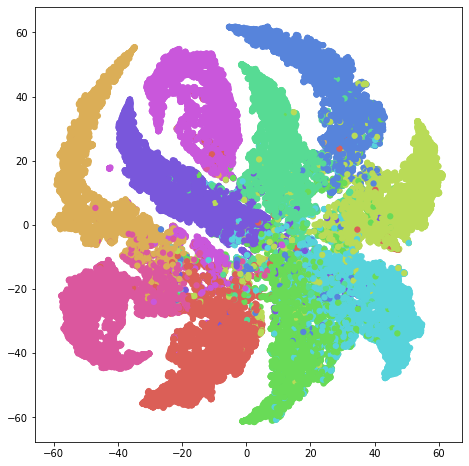

In [78]:
plot(digits_final,y_train)

In [87]:
encoded_vector=encoder.predict(x_train)

In [88]:
digits_final = TSNE(perplexity=30).fit_transform(encoded_vector) 

/home/kangjunekoo/anaconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/kangjunekoo/anaconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


/tmp/ipykernel_42283/1972440741.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

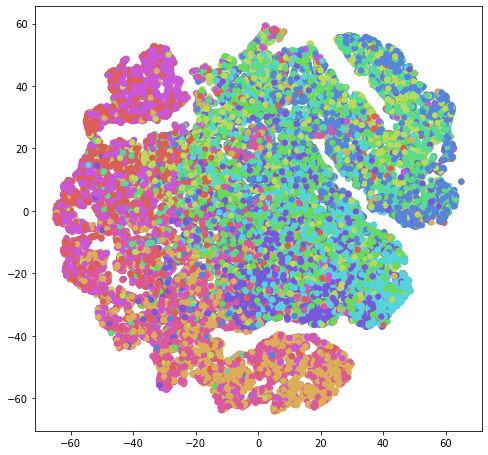

In [89]:
plot(digits_final,y_train)

In [90]:
pd.DataFrame(encoded_vector)

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,1.574485,0.00000,0.366023,0.364178,0.000000,1.133786,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.644683,1.083635,0.127709,0.000000,1.199596,0.000000,0.000000
1,0.000000,0.00000,0.000000,1.726320,0.250765,0.000000,2.537414,1.724157,0.000000,0.536445,...,1.301045,1.012253,1.878583,0.076442,0.000000,0.000000,1.650385,0.000000,0.165562,0.055333
2,1.225007,0.50104,1.319749,0.859347,0.287201,0.000000,0.464829,0.322546,0.074998,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.276820,0.000000,0.000000,0.535572,0.000000,0.261579
3,0.000000,0.00000,0.000000,0.000000,0.000000,3.138578,0.000000,0.000000,3.159817,1.548830,...,0.000000,0.000000,0.000000,1.933022,2.238024,2.384644,0.000000,1.917030,1.243901,0.000000
4,0.000000,0.00000,0.000000,0.993422,1.482425,0.000000,3.385610,0.987815,0.000000,0.690032,...,0.774895,1.944824,1.817689,0.888456,0.000000,0.000000,2.554649,0.000000,0.846786,0.991221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,2.822112,2.641371,0.000000,3.463050,...,3.268935,0.839744,1.480807,1.859634,0.000000,0.000000,3.766966,0.000000,2.493440,0.000000
49996,0.238372,0.00000,0.000000,0.000000,0.000000,1.939148,0.000000,0.000000,2.307985,0.524430,...,0.000000,0.000000,0.000000,1.008108,1.768395,1.220069,0.000000,1.387453,0.584265,0.000000
49997,0.000000,0.00000,0.000000,2.056028,0.737869,0.000000,2.440925,1.780027,0.000000,0.032460,...,1.360681,1.420809,1.693384,0.036759,0.000000,0.000000,1.750548,0.000000,0.000000,0.372413
49998,0.000000,0.00000,0.000000,0.445662,0.000000,0.000000,2.544852,2.541497,0.086896,2.824599,...,3.067405,0.621135,1.319775,1.529476,0.000000,0.000000,3.322741,0.000000,1.968775,0.000000
